# PMBot Strategy Simulation

This notebook simulates and visualizes two core components of the PMBot trading system:

- **SignalStrategy**: Detects buy/sell signals based on historical price trends and volatility.
- **ProfitStrategy**: Identifies arbitrage opportunities using token price deviations from estimated fair values.

Each strategy's logic is implemented exactly as per the original trading bot for accurate behavior testing.

In [1]:
import numpy as np
import random
from decimal import Decimal
import matplotlib.pyplot as plt

%matplotlib inline

## SignalStrategy

This strategy evaluates recent price history to determine whether to buy, sell, or hold based on:
- Slope (momentum)
- Z-score (relative price deviation)
- Standard deviation (volatility filtering)

In [2]:
class SignalStrategy:
    def __init__(self, config):
        self.price_history = []
        self.max_history = config['price_history_length']
        self.buy_slope = config['buy_slope_threshold']
        self.buy_zscore = config['buy_zscore_threshold']
        self.sell_slope = config['sell_slope_threshold']
        self.sell_zscore = config['sell_zscore_threshold']

    def evaluate_market(self, price):
        self.price_history.append(price)
        if len(self.price_history) > self.max_history:
            self.price_history.pop(0)

        if len(self.price_history) < 6:
            return "hold"

        prices = np.array(self.price_history)
        slope = np.mean(prices[-3:]) - np.mean(prices[:3])
        std_dev = np.std(prices)
        zscore = (prices[-1] - np.mean(prices)) / std_dev

        if slope > self.buy_slope and zscore > self.buy_zscore and std_dev < 0.5:
            return "buy"
        elif slope < self.sell_slope and zscore < self.sell_zscore and std_dev > 0.4:
            return "sell"
        else:
            return "hold"

### Simulate SignalStrategy Behavior

We’ll simulate price movements and evaluate the strategy’s decisions over time.

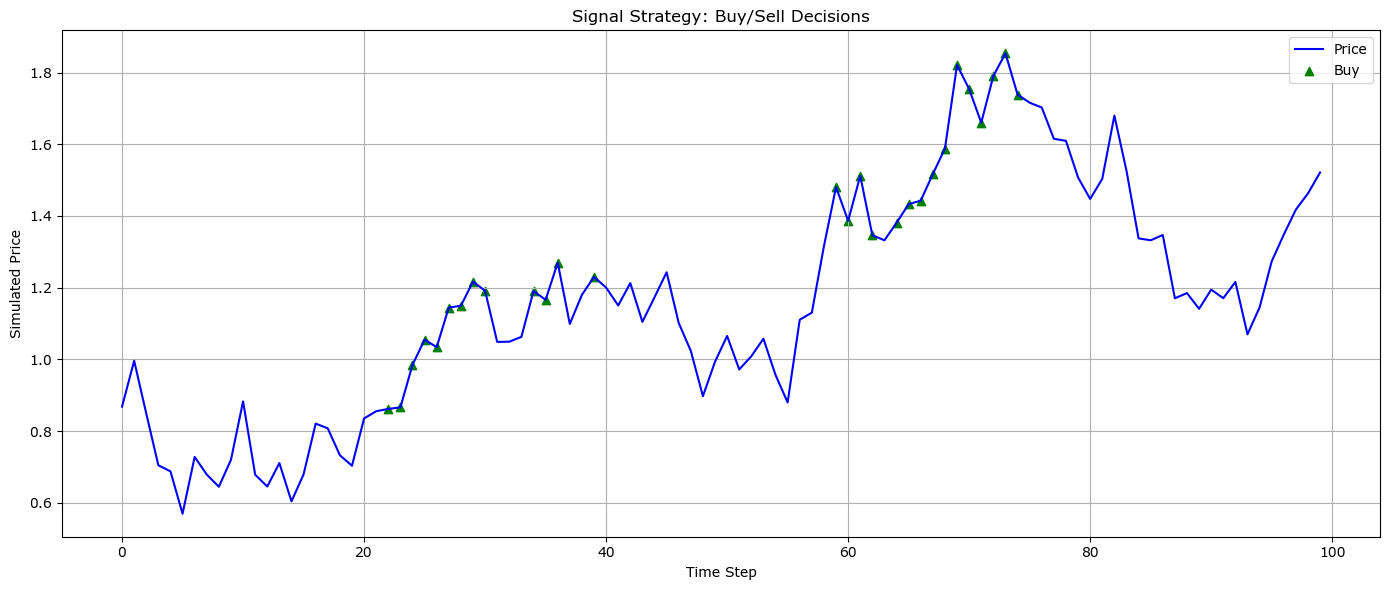

In [3]:
config = {
    "price_history_length": 20,
    "buy_slope_threshold": 0.1,
    "buy_zscore_threshold": 1.0,
    "sell_slope_threshold": -0.1,
    "sell_zscore_threshold": -1.0,
}

strategy = SignalStrategy(config)
prices = np.cumsum(np.random.normal(0, 0.1, 100)) + 1.0
decisions = [strategy.evaluate_market(p) for p in prices]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(prices, label="Price", color="blue")

for i, (price, decision) in enumerate(zip(prices, decisions)):
    if decision == "buy":
        plt.scatter(i, price, color="green", marker="^", label="Buy" if "Buy" not in plt.gca().get_legend_handles_labels()[1] else "")
    elif decision == "sell":
        plt.scatter(i, price, color="red", marker="v", label="Sell" if "Sell" not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("Signal Strategy: Buy/Sell Decisions")
plt.xlabel("Time Step")
plt.ylabel("Simulated Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ProfitStrategy

This strategy compares real-time token prices to estimated fair values and identifies arbitrage trades when price deltas exceed a threshold (±3%).

It also includes a profitability filter using `should_trade()`.

In [4]:
class OracleSimulator:
    def get_price(self, token, base):
        return Decimal(random.uniform(0.93, 1.07))

    def estimate_fair_value(self, token, base):
        return Decimal("1.00")

class ProfitStrategy:
    def __init__(self):
        self.base_token = "USDC"
        self.tokens = ["DAI", "USDT", "FRAX", "TUSD"]
        self.oracle = OracleSimulator()

    def scan_opportunities(self):
        opportunities = []
        for token in self.tokens:
            price = self.oracle.get_price(token, self.base_token)
            fair = self.oracle.estimate_fair_value(token, self.base_token)
            delta = (price - fair) / fair if fair != 0 else Decimal("0.0")

            if delta <= -0.03:
                opportunities.append((token, 'buy', delta))
            elif delta >= 0.03:
                opportunities.append((token, 'sell', delta))
        return sorted(opportunities, key=lambda x: abs(x[2]), reverse=True)

    def should_trade(self, gas_cost_eth, profit_eth):
        return profit_eth > gas_cost_eth * Decimal("1.2")

### Run ProfitStrategy Scan

Simulate multiple market snapshots to observe when opportunities are detected.

In [5]:
profit_strategy = ProfitStrategy()

print("\n--- Profit Strategy Opportunities ---\n")
for i in range(5):  # Run multiple rounds
    print(f"Scan #{i + 1}")
    opportunities = profit_strategy.scan_opportunities()
    if not opportunities:
        print("No opportunities.")
    for token, action, delta in opportunities:
        print(f"{action.upper():<4} {token:<5} | delta = {delta:.4%}")
    print("-" * 40)


--- Profit Strategy Opportunities ---

Scan #1
BUY  DAI   | delta = -6.2575%
BUY  FRAX  | delta = -4.5460%
----------------------------------------
Scan #2
BUY  DAI   | delta = -4.4987%
SELL FRAX  | delta = 3.7713%
----------------------------------------
Scan #3
SELL TUSD  | delta = 5.0324%
BUY  DAI   | delta = -4.3991%
SELL FRAX  | delta = 3.6146%
----------------------------------------
Scan #4
SELL FRAX  | delta = 4.0355%
BUY  USDT  | delta = -4.0205%
----------------------------------------
Scan #5
BUY  USDT  | delta = -4.7115%
BUY  DAI   | delta = -4.5656%
SELL TUSD  | delta = 3.5605%
BUY  FRAX  | delta = -3.1649%
----------------------------------------
